In [1]:
import os
import sys

if os.getcwd().endswith("notebooks"):
    os.chdir("..")

sys.path.append(os.path.abspath("./"))

print(f"Current work directory: {os.getcwd()}")

Current work directory: C:\Users\yyyyx\Work\OC43_machine_learning\Regression_Modeling_of_OC43_Coronavirus_Viral_Burden_from_Host_Single-cell_Transcriptomes_Using_Explainable_Machine_Learning


In [2]:
from sklearn.pipeline import Pipeline
import pandas as pd
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scanpy as sc
import joblib

In [3]:
model = joblib.load('./Data/model/Compact_cat_after_tunning.pkl')

In [4]:
df = pd.read_csv('./CSV/Bulk-seq/GSE238079_converted.csv',index_col='Gene_symbol', decimal=',')

In [5]:
df_t = df.transpose().copy()

In [6]:
df_t = (
    df_t
      .astype(str)
      .apply(lambda s: s.str.replace(',', '.', regex=False))
      .apply(pd.to_numeric, errors='coerce')
)

In [7]:
df_t.columns.name = 'Samples'

In [8]:
adata = sc.AnnData(df_t.astype(float))
adata.obs_names = df_t.index
adata.var_names = df_t.columns        

adata.var_names_make_unique()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

C:\Users\yyyyx\miniconda3\envs\ml_env\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
df_norm_log = pd.DataFrame(
    adata.X,
    index=adata.obs_names,
    columns=adata.var_names
)

In [10]:
num_features = model.feature_names_

use_cols = [c for c in num_features if c in df_norm_log.columns]

df_sub = df_norm_log[use_cols].copy()

In [11]:
y_pred = model.predict(df_sub)

In [12]:
y_pred

array([5.0793605 , 5.11883508, 5.35053728, 5.4390769 , 5.53238646,
       5.64650969])

In [13]:
df_sub['Prediction'] = y_pred

In [14]:
df_sub['Condition'] = df_sub.index.str.split('_', n=1).str[1]

condition_order = ['Mock', 'OC43_24h', 'OC43_72h']
df_sub['Condition'] = pd.Categorical(df_sub['Condition'], categories=condition_order, ordered=True)

In [15]:
baseline = df_sub[df_sub['Condition'] == 'Mock']['Prediction'].mean()

In [16]:
df_sub['Expression_Change'] = df_sub['Prediction'] - baseline

In [17]:
conditions_order = ['Mock', 'OC43_24h', 'OC43_72h']

stats = df_sub.groupby('Condition')['Expression_Change'].agg(['mean', 'std']).reindex(conditions_order)
means = stats['mean'].values
stds = stats['std'].values

In [18]:
df_sub

Samples,RPS7,ACTB,FTL,PPIA,TPI1,IFRD1,HES4,LDHA,ATP5MF,RPL23A,Prediction,Condition,Expression_Change
A_Mock,0.587324,3.061900,1.807968,1.267782,1.403100,0.260788,0.306513,1.676094,0.533810,0.411589,5.079361,Mock,-0.019737
B_Mock,0.589999,3.085583,1.834900,1.255459,1.416309,0.255373,0.293930,1.633316,0.578129,0.402214,5.118835,Mock,0.019737
A_OC43_24h,0.484250,2.775383,2.712533,1.143808,1.021891,0.446782,0.172101,1.662876,0.391159,0.358757,5.350537,OC43_24h,0.251439
B_OC43_24h,0.443904,2.811079,2.596500,1.109330,0.941049,0.467513,0.162682,1.665852,0.328445,0.346351,5.439077,OC43_24h,0.339979
A_OC43_72h,0.520926,3.589907,3.810532,1.018984,0.602237,0.628641,0.843534,0.923716,0.163124,0.393580,5.532386,OC43_72h,0.433289
B_OC43_72h,0.522364,3.336393,3.749298,1.135851,0.892479,0.744550,0.077305,1.453535,0.334352,0.371726,5.646510,OC43_72h,0.547412


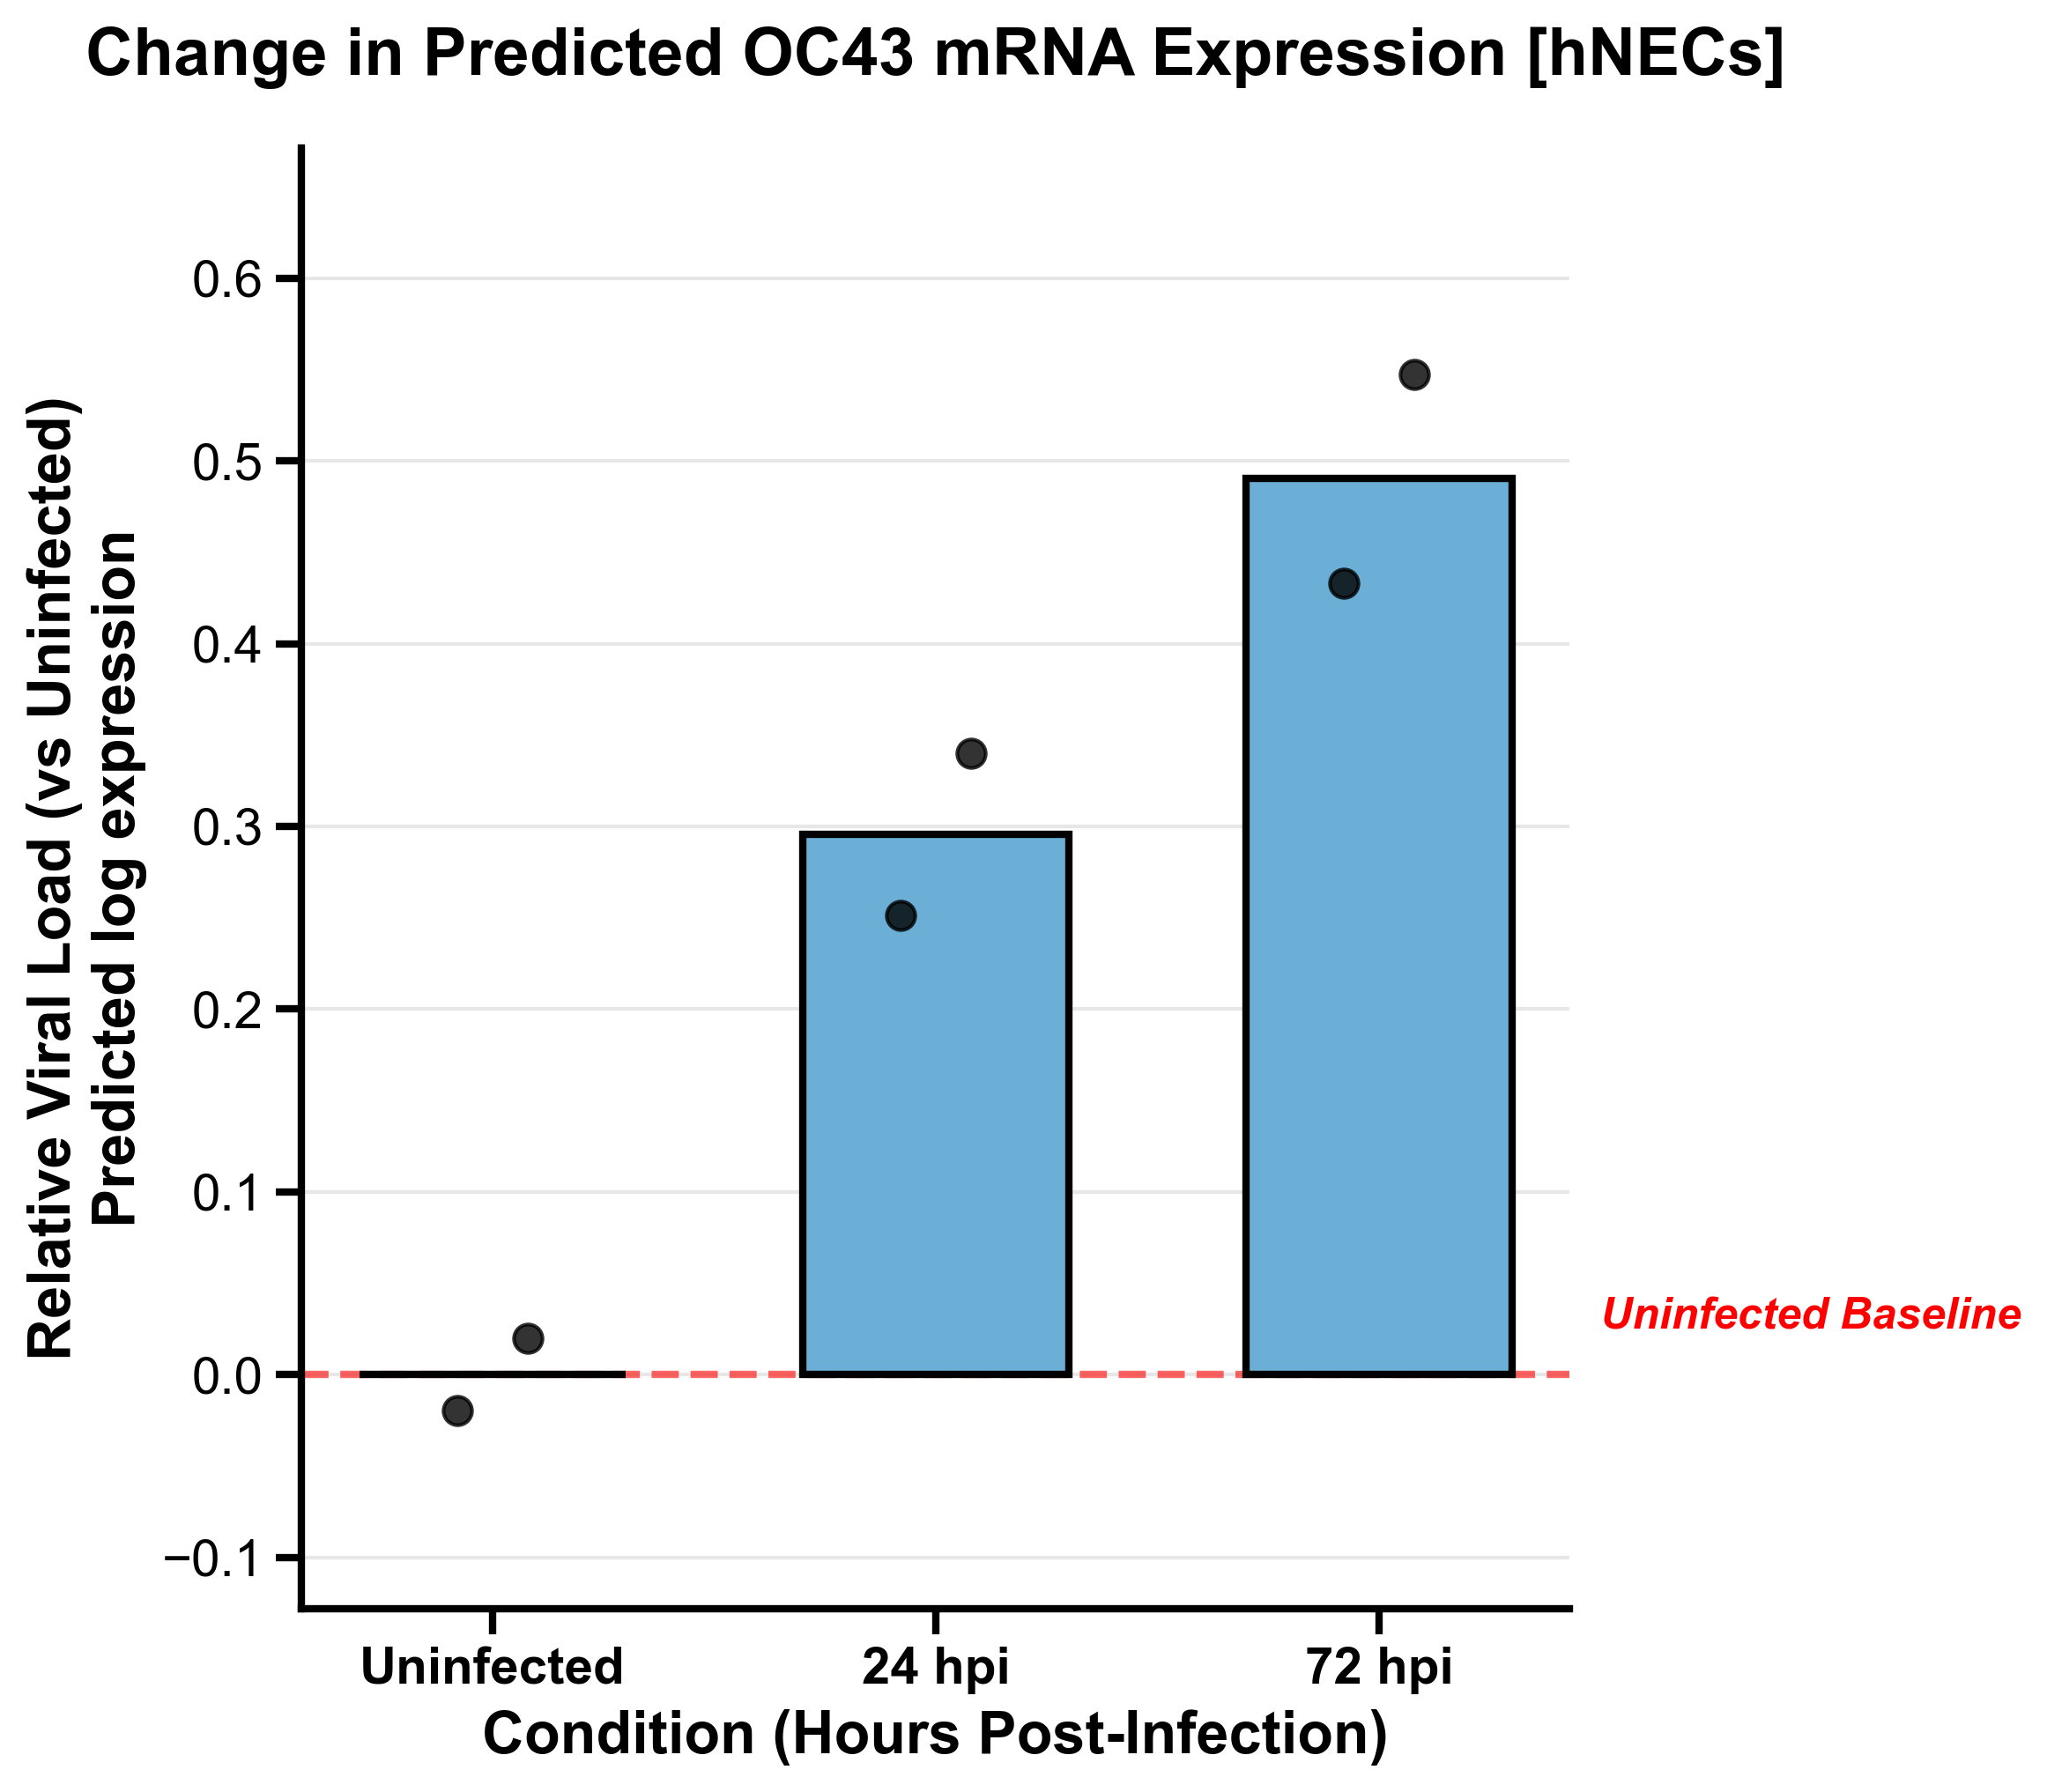

=== Condition Stat ===
                   mean       std
Condition                        
Mock      -4.440892e-16  0.027913
OC43_24h   2.957093e-01  0.062607
OC43_72h   4.903503e-01  0.080697

Sample number by each condition:
Condition
Mock        2
OC43_24h    2
OC43_72h    2
Name: count, dtype: int64


In [20]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 14,
    'axes.linewidth': 2.0,
    'xtick.major.width': 2.0,
    'ytick.major.width': 2.0,
    'xtick.major.size': 7,
    'ytick.major.size': 7,
})

fig, ax = plt.subplots(figsize=(8, 7), dpi=300)

colors = ['#969696', '#6BAED6', '#6BAED6']

bars = ax.bar(range(len(conditions_order)), means, 
               color=colors, 
               edgecolor='black', 
               linewidth=2.0,
               width=0.6,
               zorder=2)

for i, condition in enumerate(conditions_order):
    condition_data = df_sub[df_sub['Condition'] == condition]['Expression_Change']
    n_points = len(condition_data)
    if n_points == 2:
        x_positions = [i - 0.08, i + 0.08]
    else:
        x_positions = np.random.normal(i, 0.05, n_points)
    
    ax.scatter(x_positions, condition_data, 
               color='black', 
               s=60,
               alpha=0.8, 
               zorder=4)

ax.axhline(0, color='red', linestyle='--', linewidth=2.0, alpha=0.6, zorder=1)

# ==========================================
# baseline text
# ==========================================
ax.text(len(conditions_order) - 0.5, 0.02, 
        'Uninfected Baseline',         
        color='red',                  
        fontsize=12, fontweight='bold',
        style='italic',                
        ha='left', va='bottom')       

ax.set_ylabel('Relative Viral Load (vs Uninfected)\nPredicted log expression', fontsize=16, fontweight='bold')
ax.set_xlabel('Condition (Hours Post-Infection)', fontsize=16, fontweight='bold')
ax.set_title('Change in Predicted OC43 mRNA Expression [hNECs]', 
             fontsize=18, fontweight='bold', pad=20)

ax.set_xticks(range(len(conditions_order)))
ax.set_xticklabels(['Uninfected', '24 hpi', '72 hpi'], fontsize=14, fontweight='bold')

ax.tick_params(axis='y', labelsize=14)

y_min = min(means - stds) - 0.1
y_max = max(means + stds) + 0.1
ax.set_ylim(y_min, y_max)

ax.yaxis.grid(True, alpha=0.3, linestyle='-', linewidth=1.0, zorder=0)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)

plt.tight_layout()

#plt.savefig('OC43_Mock_24h_72h_hNECs_LargeFont.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# 통계 정보 출력
print("=== Condition Stat ===")
print(stats)
print(f"\nSample number by each condition:")
print(df_sub['Condition'].value_counts().reindex(conditions_order))

In [21]:
import session_info

session_info.show()